In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts

This notebook prepares common datasets for the comparisons of the predictive capabilities of various regression techniques.

The models will be trained to predict the linear-regime hole mobility ($\mu_{lin}$), reliability coefficient ($r$), on-off ratio ($on/off$), and threshold voltage ($V_{th}$). The predictions will be made based on different combinations of data that describes the device fabrication conditions and active-layer morphology.

The tested regression models are:
- LASSO
- Random Forest
- Support Vector Machine
- Naive Bayes

In other notebooks, the same datasets, as well as image-like data are used to train various neural network models. The results of these models are imported for comparison to the above models.

Below are the two dataframes for the comparison with standard regression models. `device_df` contains transistor performances for p-Si/SiO$_{2}$/OTS/P3HT/Au devices in the top-contact, bottom-gate configuration, using Indium as a gate electrode. Thermal annealing time and temperature is varied for the samples to optimize their performance.

In [2]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OFET_device_df.xlsx')
print(len(device_df))
device_df.head()

80


,Unnamed: 0,Unnamed: 0.1,Sample,Temperature,Time,Substrate,Device,mu_lin_avg,mu_lin_SD,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,0,0,75C-5min_1-IdVg-2-Vd-20,75,5,1,2,0.002176,0.000014,0.580171,0.013437,1119.582374,30.715757,-31.511376,0.198134
1,1,1,75C-5min_1-IdVg-4-Vd-20,75,5,1,4,0.004906,0.000259,0.551756,0.020972,892.258038,4.484375,-28.971871,0.461514
2,2,2,75C-5min_2-IdVg-1-Vd-20,75,5,2,1,0.004643,0.000015,0.557327,0.002400,20.595284,0.172757,-18.556867,0.166910
3,3,3,75C-5min_2-IdVg-3-Vd-20,75,5,2,3,0.012977,0.002372,0.581325,0.004444,619.347250,1024.656122,-21.054614,1.348128
4,4,4,75C-5min_2-IdVg-4-Vd-20,75,5,2,4,0.010087,0.000050,0.585769,0.006963,1812.113114,15.685197,-19.170370,0.165707


`total_df` contains morphology information. Atomic force microscopy (AFM) images were segmented and labeled into morphological domains using m2py. Those label maps were used to measure various features of the domains, which each also has an associated phase label (corresponding to P3HT-, PC$_{61}$BM-rich, or mixed regions), as determined by m2py from AFM mechanical property measurements. The average of each morphological feature for phase 1, phase 2, and phase 3 (in the AFM images of the above photovoltaic devices' active layers) are shown with their associated device processing parameters.

Note: Not every device in `device_df` has a corresponding image, so `total_df` is smaller. Further, `total_df` contains images of devices not reported in `device_df`. A subset of devices with associated AFM image are used as validation data across models

In [3]:
total_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OFET_total_df.xlsx', dtype = np.float32)
print(len(total_df))
total_df.head()

37


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,...,p2_Orient_avg,p2_Orient_stdev,p2_Perim_avg,p2_Perim_stdev,p1_fraction,p2_fraction,mu_lin_avg,r_lin_avg,on_off_avg,Vt_avg
0,0.0,10.0,100.0,3.0,1.0,15.060429,13.825294,15.094867,13.930399,0.760417,...,0.273477,1.129281,18.169495,10.105495,0.496546,0.503454,0.027205,0.751935,83456.578125,-18.385927
1,1.0,10.0,100.0,3.0,3.0,24.529301,21.770880,24.550095,21.813084,0.711369,...,0.153039,1.105821,24.341022,13.173599,0.470745,0.529255,0.038410,0.748463,133461.687500,-19.986532
2,2.0,10.0,100.0,3.0,5.0,31.114609,28.907570,31.171284,29.100225,0.725212,...,0.115643,1.031045,24.335218,14.999830,0.503413,0.496587,0.025188,0.747956,132094.093750,-20.648420
3,3.0,10.0,100.0,3.0,5.0,16.867678,12.876565,16.895245,12.918527,0.753319,...,0.101798,0.957505,14.855980,8.463103,0.501345,0.498655,0.025188,0.747956,132094.093750,-20.648420
4,4.0,10.0,100.0,4.0,3.0,23.082537,18.354319,23.096437,18.379911,0.720716,...,0.055038,1.075792,15.034619,9.558353,0.439411,0.560589,0.032493,0.732737,245995.609375,-21.035315


First, a visualization of `device_df`:

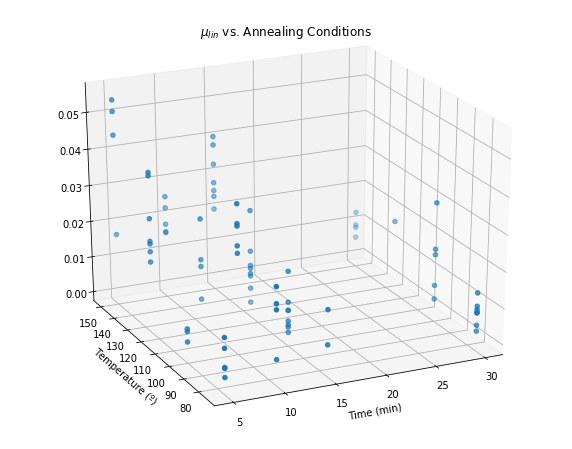

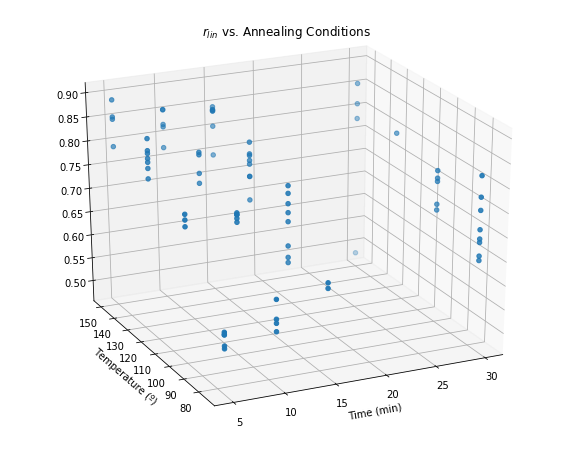

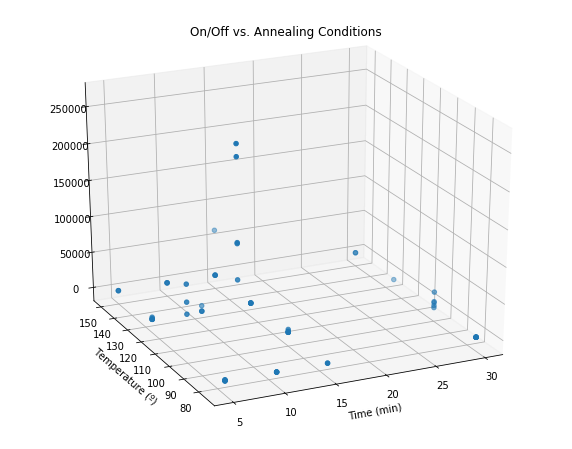

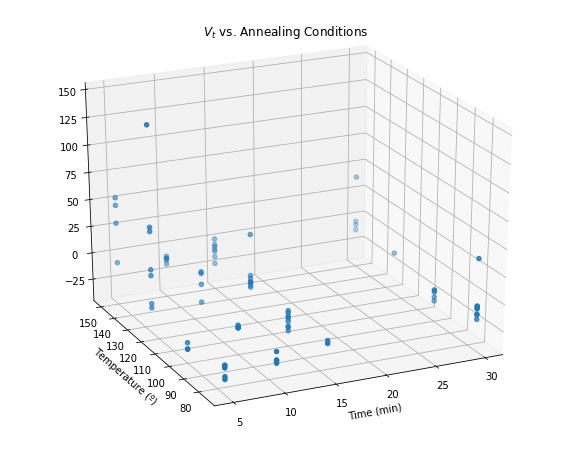

In [4]:
x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['mu_lin_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$\mu_{lin}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['r_lin_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$r_{lin}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['on_off_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('On/Off vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
# ax1.set_zscale('log')
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['Vt_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$V_{t}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

There are 5 different morphological features that m2py tracks: major axis length, minor axis length, eccentricity, perimeter, and orientation. This is implemented from `skimage.measure.region_props_table()`. In the dataframe `total_df`, the average and standard deviation of each morphological feature is tracked and is calculated per phase of each AFM image.

Shown below is the average major axis length for every phase plotted by annealing time and temperature

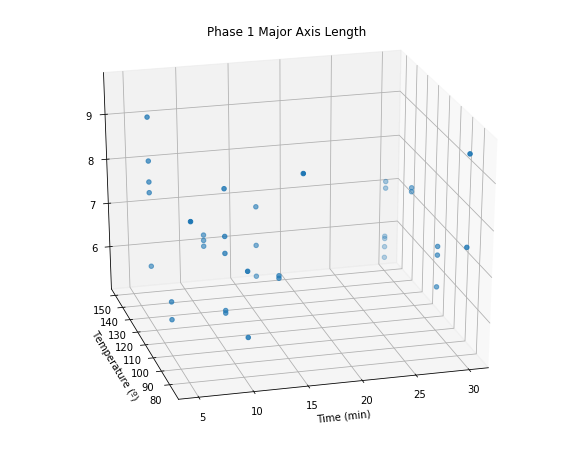

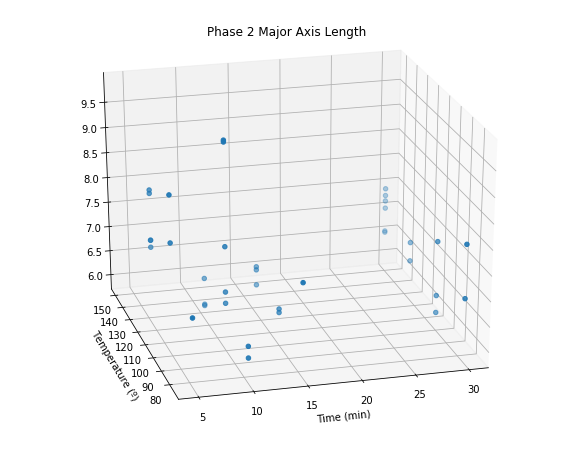

In [5]:
x1 = total_df['Anneal_time']
y1 = total_df['Anneal_temp']
z1 = total_df['p1_MajorAL_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 1 Major Axis Length')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x2 = total_df['Anneal_time']
y2 = total_df['Anneal_temp']
z2 = total_df['p2_MajorAL_avg']
fig2 = plt.figure(figsize = (10,8))
ax2 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 2 Major Axis Length')
ax2.scatter3D(x2,y2,z2)
ax2.view_init(25, 255)
plt.show()

It's well-known that neural network models can train better when their data has been normalized, especially when their different features span different ordeers of magnitude. For the NN, the data has received a MinMax normalization, where 

$$x_{normed} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

The same normalization shall be applied to this data below.

In [6]:
normed_total, normed_total_key = nuts.df_MinMax_normalize(total_df[['p1_fraction', 'p2_fraction',
                                                                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                                                                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                                                                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                                                                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                                                                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                                                                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                                                                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                                                                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                                                                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                                                                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',
                                                                   
                                                                   'mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']])
print(normed_total_key, '\n')

normed_device, normed_device_key = nuts.df_MinMax_normalize(device_df[['mu_lin_avg', 'r_lin_avg',
                                                                         'on_off_avg', 'Vt_avg']])
print(normed_device_key)

{'p1_fraction': [0.41357165575027466, 0.687556803226471], 'p2_fraction': [0.31244319677352905, 0.5864283442497253], 'p1_area_avg': [12.819910049438477, 40.458953857421875], 'p1_area_stdev': [10.819990158081055, 44.62495803833008], 'p1_filled_area_avg': [12.833333015441895, 40.51243591308594], 'p1_filled_area_stdev': [10.84469223022461, 44.70867156982422], 'p1_extent_avg': [0.6790757775306702, 0.7676778435707092], 'p1_extent_stdev': [0.1537584513425827, 0.19694925844669342], 'p1_MajorAL_avg': [5.320133209228516, 9.604105949401855], 'p1_MajorAL_stdev': [2.647315502166748, 6.4137115478515625], 'p1_MinorAL_avg': [2.8811652660369873, 5.253610610961914], 'p1_MinorAL_stdev': [1.667981743812561, 3.266883134841919], 'p1_Ecc_avg': [0.7395643591880798, 0.8095228672027588], 'p1_Ecc_stdev': [0.1854112446308136, 0.2678193747997284], 'p1_Orient_avg': [-0.03366949409246445, 0.3075425624847412], 'p1_Orient_stdev': [0.864679217338562, 1.2067605257034302], 'p1_Perim_avg': [9.990148544311523, 22.940134048

In [7]:
normed_total[['Substrate', 'Device', 'Time', 'Temperature']] = total_df[['Substrate', 'Device', 'Anneal_time', 'Anneal_temp']]

normed_device[['Substrate', 'Device', 'Time', 'Temperature']] = device_df[['Substrate', 'Device', 'Time', 'Temperature']]

Before any regression is done, the data needs to first be partitioned into training, and testing data. As noted earlier, the testing data will need to be only devices that also have corresponding AFM of their active layers. This is to be able to compare these models with neural network models trained on image data.

In [8]:
# total_df_ids = total_df[['Anneal_time', 'Anneal_temp', 'Substrate', 'Device']]
# device_df_ids = device_df[['Time (min)', 'Temp (C)', 'Substrate', 'Device']]

test_pop = pd.DataFrame()

for i in range(len(normed_total['Time'])):
    time = normed_total['Time'].iloc[i]
    temp = normed_total['Temperature'].iloc[i]
    sub = normed_total['Substrate'].iloc[i]
    dev = normed_total['Device'].iloc[i]
    
#     print(time, temp, sub, dev)

    match = device_df.query('`Time` == @time & `Temperature` == @temp & Substrate == @sub & Device == @dev')
    
#     print(match)
    
    if len(match) > 0:
        test_pop = test_pop.append(normed_total.iloc[i])
    else:
        pass
    
print(f"There are {len(test_pop)} samples in the possible testing population")
test_pop.head()

There are 27 samples in the possible testing population


,Device,Substrate,Temperature,Time,Vt_avg,mu_lin_avg,on_off_avg,p1_Ecc_avg,p1_Ecc_stdev,p1_MajorAL_avg,...,p2_Perim_avg,p2_Perim_stdev,p2_area_avg,p2_area_stdev,p2_extent_avg,p2_extent_stdev,p2_filled_area_avg,p2_filled_area_stdev,p2_fraction,r_lin_avg
0,1.0,3.0,100.0,10.0,0.156968,0.650868,0.339254,0.303153,0.721089,0.125203,...,0.486637,0.334221,0.396897,0.318864,0.947404,0.119348,0.395968,0.316088,0.697156,0.705927
1,3.0,3.0,100.0,10.0,0.137826,0.942271,0.542533,0.489469,0.133314,0.520515,...,1.000000,0.751577,0.895780,0.688662,0.297114,0.000000,0.895687,0.687487,0.791325,0.696756
2,5.0,3.0,100.0,10.0,0.129911,0.598439,0.536973,0.489821,0.173342,0.760437,...,0.999517,1.000000,1.000000,1.000000,0.497637,0.086707,1.000000,1.000000,0.672094,0.695419
3,5.0,3.0,100.0,10.0,0.129911,0.598439,0.536973,0.091904,0.475595,0.138769,...,0.211010,0.110805,0.158325,0.112266,0.565418,0.345595,0.157270,0.109458,0.679643,0.695419
4,3.0,4.0,100.0,10.0,0.125284,0.788403,1.000000,0.461287,0.189111,0.434019,...,0.225870,0.259793,0.171336,0.189400,0.463749,0.551223,0.170850,0.188174,0.905691,0.655215


Because we have 27 of 37 possible testing samples in `total_df`, 10 are selected at random for testing

In [9]:
total_test = test_pop.sample(n = 10)
total_test.head()

,Device,Substrate,Temperature,Time,Vt_avg,mu_lin_avg,on_off_avg,p1_Ecc_avg,p1_Ecc_stdev,p1_MajorAL_avg,...,p2_Perim_avg,p2_Perim_stdev,p2_area_avg,p2_area_stdev,p2_extent_avg,p2_extent_stdev,p2_filled_area_avg,p2_filled_area_stdev,p2_fraction,r_lin_avg
12,1.0,3.0,125.0,10.0,0.084958,0.351318,3.138083e-02,0.415556,0.251045,0.374438,...,0.112565,0.051511,0.085389,0.060618,0.672641,0.590192,0.083907,0.057546,1.000000,0.718592
20,1.0,1.0,125.0,5.0,0.158644,0.391265,6.849715e-03,0.665397,0.386017,0.672876,...,0.501130,0.616763,0.413172,0.454329,0.481098,0.677566,0.412517,0.452487,0.657698,0.872806
23,2.0,2.0,125.0,5.0,0.953270,0.699581,9.042762e-07,0.524442,0.032338,0.779455,...,0.357580,0.446809,0.280503,0.320787,0.537091,0.505003,0.283717,0.327492,0.241549,1.000000
26,2.0,7.0,150.0,30.0,0.350601,0.283138,1.134871e-04,0.235623,0.834499,0.059090,...,0.360900,0.274119,0.278919,0.236745,0.710016,0.213944,0.278246,0.234964,0.639534,0.000000
4,3.0,4.0,100.0,10.0,0.125284,0.788403,1.000000e+00,0.461287,0.189111,0.434019,...,0.225870,0.259793,0.171336,0.189400,0.463749,0.551223,0.170850,0.188174,0.905691,0.655215


So, the training data is now our original dataframes, minus the testing data samples

In [10]:
total_train = normed_total.copy()
print(len(total_train))

index = total_test.index
print(index)
    
total_train = total_train.drop(index)
print(len(total_train))

37
Int64Index([12, 20, 23, 26, 4, 31, 13, 5, 2, 22], dtype='int64')
27


Because the `device_df` trained regressors can make predictions on the `total_df` test data set, there is no need to split `device_df` into training and testing data

# Now it's time to save and visualize the final datasets

In [11]:
normed_device.to_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OFET_device.xlsx')
total_train.to_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OFET_train.xlsx')
total_test.to_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OFET_test.xlsx')


In [22]:
dev_only_x = normed_device[['Time', 'Temperature)']]
dev_only_y = normed_device[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']]
x_train = total_train[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg',
                       'Ecc_avg', 'Orient_avg', 'Perim_avg']]
y_train = total_train[['PCE', 'VocL', 'Jsc', 'FF']]
x_test = total_test[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg',
                       'Ecc_avg', 'Orient_avg', 'Perim_avg']]
y_test = total_test[['PCE', 'VocL', 'Jsc', 'FF']]

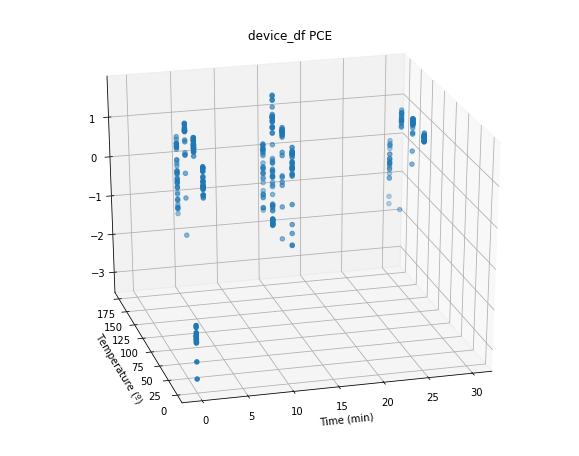

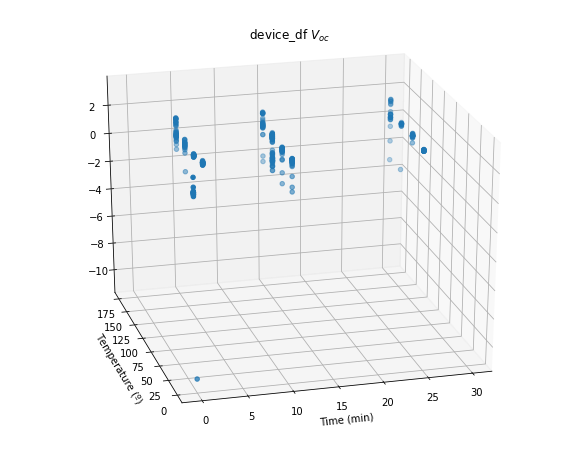

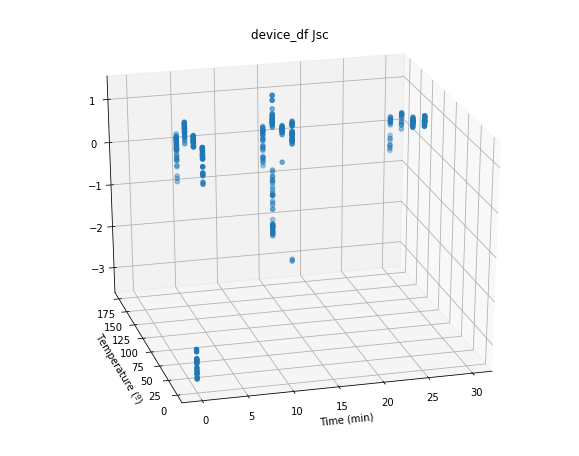

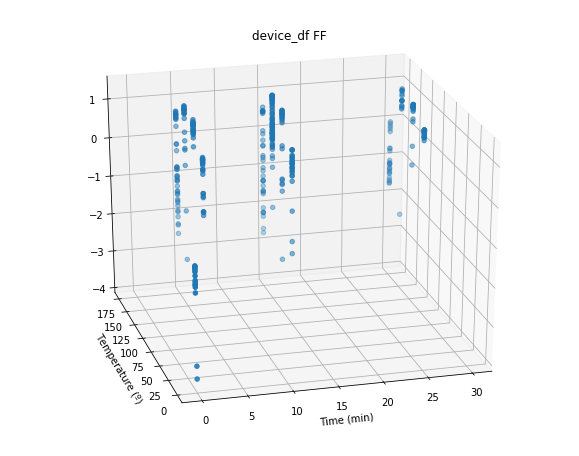

In [17]:
x1 = dev_only_x['Time (min)']
y1 = dev_only_x['Temp (C)']
z1 = dev_only_y['PCE']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('device_df PCE')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = dev_only_x['Time (min)']
y1 = dev_only_x['Temp (C)']
z1 = dev_only_y['VocL']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('device_df $V_{oc}$')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = dev_only_x['Time (min)']
y1 = dev_only_x['Temp (C)']
z1 = dev_only_y['Jsc']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('device_df Jsc')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = dev_only_x['Time (min)']
y1 = dev_only_x['Temp (C)']
z1 = dev_only_y['FF']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('device_df FF')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

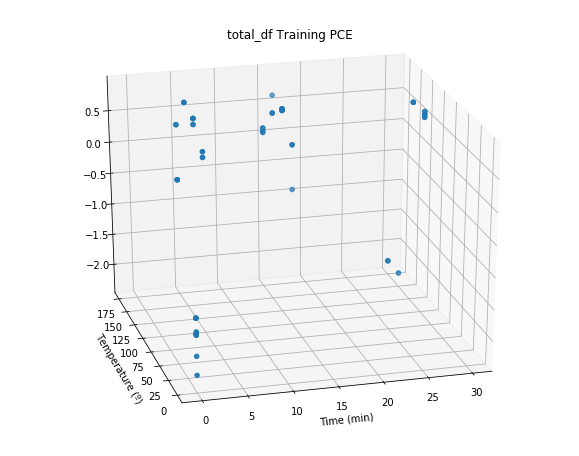

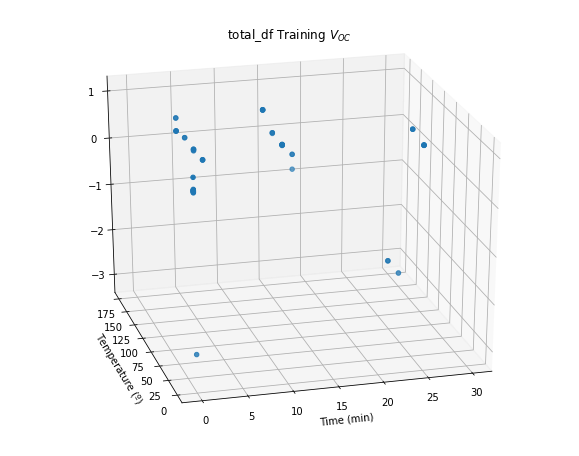

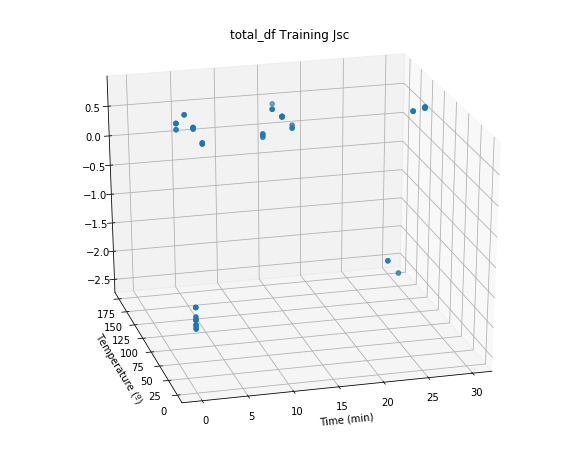

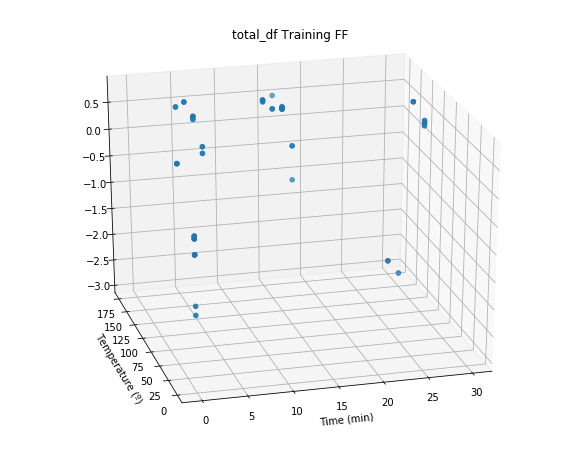

In [18]:
x1 = x_train['Anneal_time']
y1 = x_train['Anneal_temp']
z1 = y_train['PCE']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training PCE')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_train['Anneal_time']
y1 = x_train['Anneal_temp']
z1 = y_train['VocL']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training $V_{OC}$')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_train['Anneal_time']
y1 = x_train['Anneal_temp']
z1 = y_train['Jsc']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training Jsc')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_train['Anneal_time']
y1 = x_train['Anneal_temp']
z1 = y_train['FF']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training FF')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

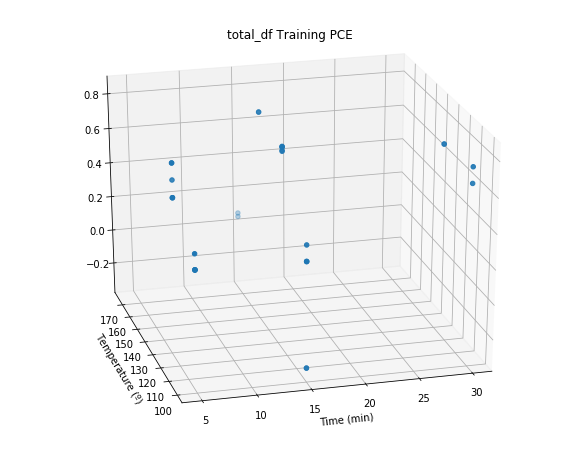

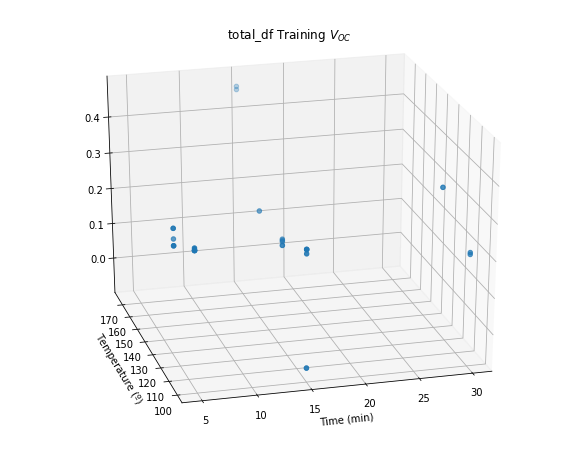

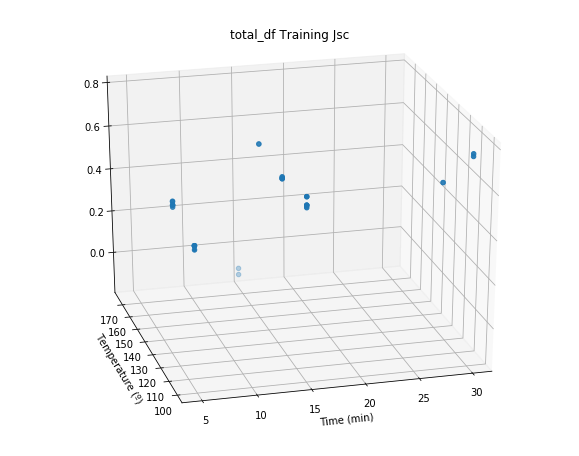

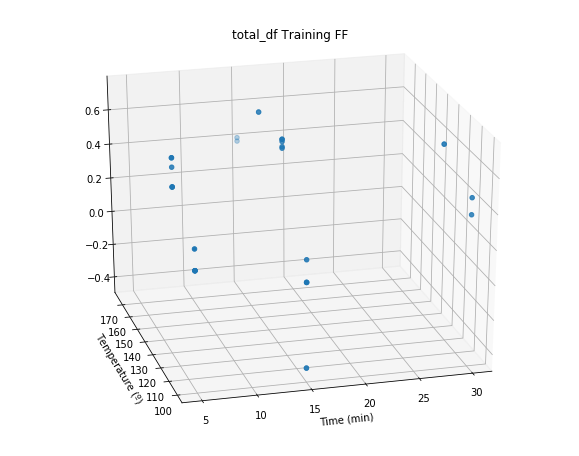

In [19]:
x1 = x_test['Anneal_time']
y1 = x_test['Anneal_temp']
z1 = y_test['PCE']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training PCE')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_test['Anneal_time']
y1 = x_test['Anneal_temp']
z1 = y_test['VocL']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training $V_{OC}$')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_test['Anneal_time']
y1 = x_test['Anneal_temp']
z1 = y_test['Jsc']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training Jsc')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x1 = x_test['Anneal_time']
y1 = x_test['Anneal_temp']
z1 = y_test['FF']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('total_df Training FF')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()